In [33]:
import requests as req
import pandas as pd
import json
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pytz

In [34]:
tz = pytz.timezone('Europe/Berlin')

tz.localize(datetime.today()).date()

datetime.date(2022, 3, 4)

In [35]:
def api_wrapper(query, start_date, api_key):
    api_str = f'https://content.guardianapis.com/search?q="{query}"&from-date={start_date}&order-by=oldest&api-key={api_key}&type=article&page-size=50&show-fields=body'
    # &query-fields=headline  don't know if I want or should use this
    response = req.get(api_str).content
    response_json = json.loads(response)
    cols = ['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl', 'body']
    df = pd.DataFrame(columns = cols)
    return response_json, api_str, df

In [36]:
def data_to_df(response_json, api_str, df):  
    pages = response_json['response']['pages']
    for i in range(1, pages + 1):
        response = req.get(api_str + f'&page={i}').content
        response_json = json.loads(response)
        for entry in response_json['response']['results']:
            keys = ['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl']
            write_entry = {k: entry[k] for k in keys}
            write_entry['body'] = entry['fields']['body']
            df = df.append(write_entry, ignore_index=True)
    
    df['Date'] = pd.to_datetime(df['webPublicationDate']).dt.tz_convert(tz='Europe/Berlin')
    df['body'] = df['body'].str.replace(r'<.*?>', '', regex=True)

    return df

In [37]:
def get_result(df):
    df = df.set_index('Date')
    df_grouped = df.groupby(lambda x: x.date).size().reset_index(name='numberOfArticles')
    df_grouped = df_grouped.set_index('index')

    berlin = pytz.timezone('Europe/Berlin')
    date_range = pd.date_range(min(df.index), berlin.localize(datetime.today())).date
    df_grouped = df_grouped.reindex(index = date_range, fill_value=0)

    main_section = df['sectionName'].value_counts().index.tolist()[0]
    avg_articles = df_grouped['numberOfArticles'].mean()
    std_dev = df_grouped['numberOfArticles'].std()

    return df_grouped, main_section, avg_articles, std_dev

In [38]:
query = 'Trudeau'
start_date = '2018-01-01'
api_key = "91f67b2a-520b-4f9f-a4ca-edcb0d610454"

my_json, api_str, df = api_wrapper(query, start_date, api_key)
df = data_to_df(my_json, api_str, df)
result_df, main_section, avg_articles, std_dev = get_result(df)

result_df

,numberOfArticles
index,
2018-01-01,1
2018-01-02,0
2018-01-03,1
2018-01-04,0
2018-01-05,0
...,...
2022-02-27,0
2022-02-28,1
2022-03-01,0


In [39]:
full_df = df

In [40]:
print(avg_articles)
print(std_dev)

0.5745239658568615
1.0575712666999362


In [41]:
pd.date_range(min(df.index), max(df.index)).date

array([datetime.date(1970, 1, 1)], dtype=object)

## Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

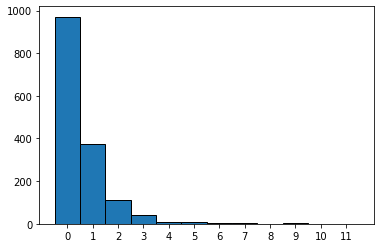

In [42]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.show

<ipython-input-43-2fc9535be686>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<function matplotlib.pyplot.show(close=None, block=None)>

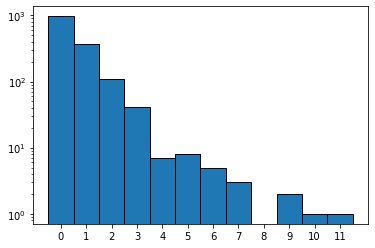

In [43]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.yscale('log', nonposy='clip')
plt.show

In [44]:
# setting window size and confidence level in terms of 
# stander deviations
window_size = 7
num_stds = 3

# calculation of moving average + mean and std deviation
result_df['MA'] = result_df.rolling(window=window_size).mean()
ma_mean = result_df['MA'].mean()
ma_std = result_df['MA'].std()

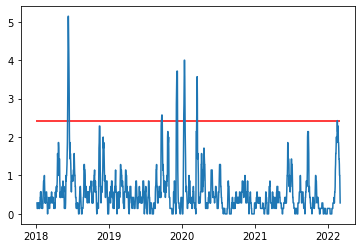

In [45]:
# visualization of the moving average
# and the std line
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots()
ax.plot(result_df.index, result_df.MA)
ax.hlines(y=ma_mean + num_stds * ma_std, xmin=min(result_df.index), xmax=max(result_df.index), color='r')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(years_fmt)

In [46]:
# create df containing spikes in articles
pd.set_option('display.max_rows', 100)
spikes_df = result_df.loc[result_df.MA > ma_mean + num_stds * ma_std ]

In [47]:
spikes_df['date'] = spikes_df.index
# test_df['delta'] = (test_df['date'] - test_df['date'].shift()).fillna(pd.Timedelta(0))
groups = spikes_df['date'].diff().gt(f'{window_size} days').cumsum()
dfs = [x for _, x in spikes_df.groupby(groups)]
print(len(dfs))
dfs

6


<ipython-input-47-51b5b66b8efb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spikes_df['date'] = spikes_df.index


[            numberOfArticles        MA        date
 index                                             
 2018-06-09                 5  2.571429  2018-06-09
 2018-06-10                 5  3.142857  2018-06-10
 2018-06-11                 9  4.428571  2018-06-11
 2018-06-12                 6  5.142857  2018-06-12
 2018-06-13                 2  5.142857  2018-06-13
 2018-06-14                 1  4.714286  2018-06-14
 2018-06-15                 3  4.428571  2018-06-15
 2018-06-16                 0  3.714286  2018-06-16
 2018-06-17                 1  3.142857  2018-06-17,
             numberOfArticles        MA        date
 index                                             
 2019-09-21                 1  2.428571  2019-09-21
 2019-09-22                 0  2.428571  2019-09-22
 2019-09-23                 1  2.571429  2019-09-23
 2019-09-24                 2  2.571429  2019-09-24
 2019-09-25                 1  2.571429  2019-09-25,
             numberOfArticles        MA        date
 index    

In [48]:
# probably makes everything easier
result_df['date'] = pd.to_datetime(result_df.index).date

In [74]:
# for df in dfs:
#     df = result_df.loc[(result_df.date >= df.iloc[0].date - pd.to_timedelta(f'{window_size} days')) &
#                     (result_df.date <= df.iloc[-1].date)]
dfs = [result_df.loc[(result_df.date >= df.iloc[0].date - pd.to_timedelta(f'{window_size} days')) &
                    (result_df.date <= df.iloc[-1].date)] for df in dfs]

## Topic Modelling

In [76]:
# data preparation
full_df.Date = pd.to_datetime(full_df.Date).dt.date
lda_df = full_df.loc[full_df.Date.isin(dfs[0].date)]

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,body,Date
79,world/2018/jun/03/justin-trudeau-donald-trump-...,article,world,World news,2018-06-03T15:41:43Z,Trudeau calls Trump's tariffs 'insulting' to l...,https://www.theguardian.com/world/2018/jun/03/...,"Justin Trudeau, the Canadian prime minister, o...",2018-06-03
80,us-news/2018/jun/05/trump-nafta-canada-mexico-...,article,business,Business,2018-06-05T14:30:48Z,Trump may seek separate Nafta talks with Canad...,https://www.theguardian.com/us-news/2018/jun/0...,Donald Trump may seek separate talks with Cana...,2018-06-05
81,world/commentisfree/2018/jun/06/canada-cannabi...,article,world,World news,2018-06-06T06:00:05Z,I served 20 years for cannabis. Now the police...,https://www.theguardian.com/world/commentisfre...,"Over the course of my life, I have been convic...",2018-06-06
82,us-news/2018/jun/06/donald-trump-justin-trudea...,article,us-news,US news,2018-06-06T21:01:59Z,Trump to Trudeau in testy tariff call: 'Didn't...,https://www.theguardian.com/us-news/2018/jun/0...,He has criticized Canada’s trade polices as “u...,2018-06-06
83,world/2018/jun/07/thursday-briefing-carry-on-l...,article,world,World news,2018-06-07T05:30:28Z,"Thursday briefing: Carry on liquidating, at ta...",https://www.theguardian.com/world/2018/jun/07/...,Top story: Carillion advisers ‘pocket millions...,2018-06-07
84,world/2018/jun/07/the-g7-minus-one-trump-packs...,article,world,World news,2018-06-07T10:57:16Z,The G7 minus one: Trump packs wrecking ball fo...,https://www.theguardian.com/world/2018/jun/07/...,The Québécois police have been erecting high s...,2018-06-07
85,australia-news/2018/jun/08/morning-mail-surgeo...,article,australia-news,Australia news,2018-06-07T21:18:01Z,Morning mail: surgeon accused of operating on ...,https://www.theguardian.com/australia-news/201...,"Good morning, this is Richard Parkin bringing ...",2018-06-07
86,world/2018/jun/07/g7-summit-will-be-a-politica...,article,world,World news,2018-06-07T21:34:42Z,G7 summit will be a political fistfight for Eu...,https://www.theguardian.com/world/2018/jun/07/...,"Theresa May landed in Quebec on Thursday, swap...",2018-06-07
87,world/2018/jun/07/macron-g7-summit-trump-trade...,article,world,World news,2018-06-07T23:25:08Z,Macron calls on G7 members to confront Trump o...,https://www.theguardian.com/world/2018/jun/07/...,Emmanuel Macron has called on other members of...,2018-06-08
88,world/2018/jun/08/canada-closer-to-legalising-...,article,world,World news,2018-06-08T03:21:24Z,Canada closer to legalising marijuana after se...,https://www.theguardian.com/world/2018/jun/08/...,Canada’s senate has voted to legalise recreati...,2018-06-08


TODO:  
- select the correct dates (no distance > 7 days)
- select all the text bodies from articles
- do topic modelling for each special event time frame
- answer question for reason of rise in articles